In [7]:
!pip install --upgrade pyspark_dist_explore

Requirement not upgraded as not directly required: numpy in /opt/anaconda/lib/python3.6/site-packages (from pyspark_dist_explore) (1.15.0)
Requirement not upgraded as not directly required: pandas in /opt/anaconda/lib/python3.6/site-packages (from pyspark_dist_explore) (0.23.3)
Requirement not upgraded as not directly required: scipy in /opt/anaconda/lib/python3.6/site-packages (from pyspark_dist_explore) (1.1.0)
Requirement not upgraded as not directly required: matplotlib in /opt/anaconda/lib/python3.6/site-packages (from pyspark_dist_explore) (2.2.2)
Requirement not upgraded as not directly required: python-dateutil>=2.5.0 in /opt/anaconda/lib/python3.6/site-packages (from pandas->pyspark_dist_explore) (2.7.3)
Requirement not upgraded as not directly required: pytz>=2011k in /opt/anaconda/lib/python3.6/site-packages (from pandas->pyspark_dist_explore) (2018.5)
Requirement not upgraded as not directly required: cycler>=0.10 in /opt/anaconda/lib/python3.6/site-packages (from matplotli

In [8]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import functions as F, types, SQLContext
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [9]:
%reload_ext autoreload
%autoreload 2

In [10]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [11]:
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [12]:
sqlContext = SQLContext(sc)

In [13]:
# TODO: Replace <FILL IN> with appropriate code
def parse_point(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    values = point.split(',')[1:]
    #values = filter(None, values)
    indices = range(len(values))
    return zip(indices,values)



In [14]:
from pyspark.sql.functions import udf, split
from pyspark.sql.types import ArrayType, StructType, StructField, LongType, StringType, FloatType, DoubleType


parse_point_udf = udf(parse_point, ArrayType(StructType([StructField('_1', LongType()),StructField('_2', StringType())])))

def parse_raw_df(raw_df):
    """Convert a DataFrame consisting of rows of comma separated text into labels and feature.


    Args:
        raw_df (DataFrame with a 'text' column): DataFrame containing the raw comma separated data.

    Returns:
        DataFrame: A DataFrame with 'label' and 'feature' columns.   
  
    """
    return (raw_df.select(split(raw_df.text,',').getItem(0).cast("double").alias('label'),
                         parse_point_udf(raw_df.text).alias('features'))
                        .cache())

In [15]:
def create_one_hot_dict(input_df):
    """Creates a one-hot-encoder dictionary based on the input data.

    Args:
        input_df (DataFrame with 'features' column): A DataFrame where each row contains a list of
            (featureID, value) tuples.

    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    input_distinct_feats_df = input_df.select(explode(input_df.features)).distinct()
    input_ohe_dict = (input_distinct_feats_df
                     .rdd
                     .map(lambda r: tuple(r[0]))
                     .zipWithIndex().collectAsMap())
    return input_ohe_dict

In [16]:
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import VectorUDT

def ohe_udf_generator(ohe_dict_broadcast):
    """Generate a UDF that is setup to one-hot-encode rows with the given dictionary.

    Note:
        We'll reuse this function to generate a UDF that can one-hot-encode rows based on a
        one-hot-encoding dictionary built from the training data.  Also, you should calculate
        the number of features before calling the one_hot_encoding function.

    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.

    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value)
    return udf(lambda x: one_hot_encoding(x, ohe_dict_broadcast, length), VectorUDT())


In [17]:
from pyspark.mllib.linalg import SparseVector
def one_hot_encoding(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted.

    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    indices = sorted([ohe_dict_broadcast.value[feat] for feat in raw_feats])
    values = np.ones(len(raw_feats))
    return SparseVector(num_ohe_feats,indices,values)

In [18]:
toy_rawDF = sqlContext.read.text('Toy_Example_Data.csv').withColumnRenamed("value", "text")

In [19]:
toy_rawDF.show()

+--------------------+
|                text|
+--------------------+
|1,4,6.37,2.85,0,A...|
|1,5,7.84,3.91,1,S...|
|1,2,5.5,2.82,1,St...|
|1,3,8.43,1.92,1,E...|
|0,4,6.29,3.43,1,F...|
|1,4,8.36,1.91,1,J...|
|1,4,6.56,3.61,1,B...|
|0,2,7.98,1.96,0,F...|
|1,4,5.52,2.85,0,C...|
|1,3,9.15,3.34,0,F...|
|1,4,6.14,1.82,1,M...|
|0,4,6.87,1.75,1,J...|
|1,3,6.9,3.84,1,Sp...|
|1,2,6.53,1.57,0,A...|
|1,4,9.98,3.66,1,S...|
|0,2,9.78,2.81,1,M...|
|0,2,5.1,3.32,1,St...|
|1,3,5.32,3.62,1,A...|
|1,2,7.16,3.72,1,C...|
|0,3,6.07,2.29,0,R...|
+--------------------+
only showing top 20 rows



In [20]:
weights = [.8, .1, .1]
seed = 42
# Use randomSplit with weights and seed
raw_train_df, raw_validation_df, raw_test_df = toy_rawDF.randomSplit(weights, seed)

# Cache and count the DataFrames
n_train = raw_train_df.cache().count()
n_val = raw_validation_df.cache().count()
n_test = raw_test_df.cache().count()
print(n_train, n_val, n_test, str(n_train + n_val + n_test))

806 94 100 1000


In [22]:
parsed_train_df = parse_raw_df(raw_train_df)
print(parsed_train_df.head())

Row(label=0.0, features=[Row(_1=0, _2='2'), Row(_1=1, _2='5.01'), Row(_1=2, _2='2.41'), Row(_1=3, _2='1'), Row(_1=4, _2='Math'), Row(_1=5, _2='German')])


In [23]:
from pyspark.sql.functions import (explode, col)
num_categories = (parsed_train_df
                    .select(explode('features').alias('features'))
                    .distinct()
                    .select(col('features').getField('_1').alias('featureNumber'))
                    .groupBy('featureNumber')
                    .sum()
                    .orderBy('featureNumber')
                    .collect())

In [24]:
print(num_categories)

[Row(featureNumber=0, sum(featureNumber)=0), Row(featureNumber=1, sum(featureNumber)=402), Row(featureNumber=2, sum(featureNumber)=480), Row(featureNumber=3, sum(featureNumber)=6), Row(featureNumber=4, sum(featureNumber)=68), Row(featureNumber=5, sum(featureNumber)=85)]


In [27]:
ctr_ohe_dict = create_one_hot_dict(parsed_train_df)
num_ctr_ohe_feats = len(ctr_ohe_dict)
print(num_ctr_ohe_feats)

682


In [28]:
ohe_dict_broadcast = sc.broadcast(ctr_ohe_dict)
ohe_dict_udf =  ohe_udf_generator(ohe_dict_broadcast)
ohe_train_df =  parsed_train_df.select( ohe_dict_udf(parsed_train_df.features).alias('features'),parsed_train_df.label,)
#ohe_train_df.show(1)                  

print(ohe_train_df.count())
print(ohe_train_df.show())
print(ohe_train_df.take(1))

806
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(682,[82,113,117,...|  0.0|
|(682,[23,82,185,3...|  0.0|
|(682,[70,82,234,2...|  0.0|
|(682,[82,355,418,...|  0.0|
|(682,[82,462,576,...|  0.0|
|(682,[176,378,418...|  0.0|
|(682,[260,378,418...|  0.0|
|(682,[378,414,447...|  0.0|
|(682,[217,378,522...|  0.0|
|(682,[235,378,536...|  0.0|
|(682,[82,151,152,...|  0.0|
|(682,[82,230,272,...|  0.0|
|(682,[160,227,378...|  0.0|
|(682,[82,153,160,...|  0.0|
|(682,[131,182,348...|  0.0|
|(682,[67,82,137,5...|  0.0|
|(682,[32,137,250,...|  0.0|
|(682,[82,137,154,...|  0.0|
|(682,[117,267,330...|  0.0|
|(682,[82,144,370,...|  0.0|
+--------------------+-----+
only showing top 20 rows

None
[Row(features=SparseVector(682, {82: 1.0, 113: 1.0, 117: 1.0, 413: 1.0, 502: 1.0, 674: 1.0}), label=0.0)]


In [29]:
ohe_train_rdd = ohe_train_df \
                     .rdd \
                     .cache()

In [30]:
meanDropOut = ohe_train_rdd.map(lambda x: x[1]).mean()
varDropOut = ohe_train_rdd.map(lambda x: x[1]).variance()
print(f"Mean: {meanDropOut}")
print(f"Variance: {varDropOut}")

Mean: 0.6625310173697274
Variance: 0.2235836683927612


In [31]:
BASELINE = np.append(meanDropOut, np.zeros(num_ctr_ohe_feats))

In [32]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [33]:
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        ############## YOUR CODE HERE #############
        model = GDUpdate(trainRDD, model, learningRate)
        training_loss = LogLoss(trainRDD, model) 
        test_loss = LogLoss(testRDD, model)
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [34]:
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log loss')
    if title:
        plt.title(title)
    plt.show()

In [35]:
def LogLoss(dataRDD, W):
    """
    Compute log loss.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    #augmentedData = dataRDD.map(lambda x: ( x[0], np.append([1.0], x[1]))).cache()
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    ################## YOUR CODE HERE ##################
    #loss = augmentedData.map(lambda x: (-x[0] * np.log(sigmoid(W.dot(x[1]))) - (1 - x[0]) * np.log(1 - sigmoid(W.dot(x[1])))) ).mean()
    loss = augmentedData.map(lambda x: (-x[1] * np.log(sigmoid(W.dot(x[0]))) \
                                     - (1 - x[1]) * np.log(1 - sigmoid(W.dot(x[0])))) ).mean()
    ################## (END) YOUR CODE ##################
    return loss

In [44]:
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    #augmentedData = dataRDD.map(lambda x: ( x[0], np.append([1.0], x[1]))).cache()
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    ################## YOUR CODE HERE ################# 
    #grad = augmentedData.map(lambda x: (sigmoid(W.dot(x[1])) - x[0])*x[1]).mean()
    grad = augmentedData.map(lambda x: np.dot(sigmoid(W.dot(x[0]) - x[1]),x[0])).mean()
    new_model = W - learningRate * grad
    ################## (END) YOUR CODE ################# 
    
    return new_model

In [47]:
# <--- SOLUTION --->
# part b - OLS gradient descent function
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.01, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        ############## YOUR CODE HERE #############
        model = GDUpdate(trainRDD, model, learningRate)
        training_loss = LogLoss(trainRDD, model) 
        test_loss = LogLoss(testRDD, model)
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [38]:
# plot error curves - RUN THIS CELL AS IS
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    plt.show()

In [40]:
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {LogLoss(ohe_train_rdd,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(ohe_train_rdd, model)
    loss = LogLoss(ohe_train_rdd, model)
    print(f"Loss: {loss}")
  #  print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.6393586657271466
----------
STEP: 1
Loss: 0.6405834992567013
----------
STEP: 2
Loss: 0.643721487215732
----------
STEP: 3
Loss: 0.6485545689963543
----------
STEP: 4
Loss: 0.6548778151932536
----------
STEP: 5
Loss: 0.6625012704436208


In [48]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = ohe_train_rdd.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
train, test, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 20)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 20 iterations in 321.46514868736267 seconds


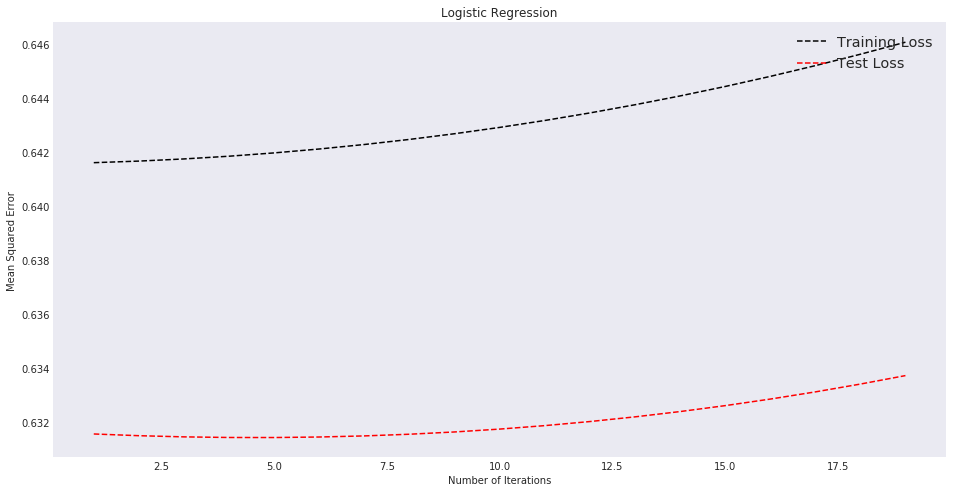

In [49]:
# take a look (RUN THIS CELL AS IS)
plotErrorCurves(train, test, title = 'Logistic Regression' )

In [ ]:
np.savetxt(PWD + 'LLmodels.csv', np.array(models), delimiter=',')

In [53]:
#test
parsed_test_df = parse_raw_df(raw_test_df)
print(parsed_test_df.head())
ohe_test_df = parsed_test_df.select( ohe_dict_udf(parsed_test_df.features).alias('features'),parsed_test_df.label,)


Row(label=0.0, features=[Row(_1=0, _2='2'), Row(_1=1, _2='5.1'), Row(_1=2, _2='3.32'), Row(_1=3, _2='1'), Row(_1=4, _2='Statistics'), Row(_1=5, _2='Astronomy')])


In [54]:
ohe_test_rdd = ohe_test_df \
                     .rdd \
                     .cache()

In [56]:
MSE = LogLoss(ohe_test_rdd, model)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 337.0 failed 1 times, most recent failure: Lost task 0.0 in stage 337.0 (TID 1731, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 230, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 225, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 324, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 139, in dump_stream
    for obj in iterator:
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 313, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 73, in <lambda>
    return lambda *a: toInternal(f(*a))
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-16-1b2f8fe53328>", line 22, in <lambda>
  File "<ipython-input-17-c10889137571>", line 21, in one_hot_encoding
  File "<ipython-input-17-c10889137571>", line 21, in <listcomp>
KeyError: Row(_1=1, _2='7.73')

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:66)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:153)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsBytes(MemoryStore.scala:378)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1109)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1083)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1018)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1083)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:809)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:64)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD$$anonfun$7.apply(RDD.scala:337)
	at org.apache.spark.rdd.RDD$$anonfun$7.apply(RDD.scala:335)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1109)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1083)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1018)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1083)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:809)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:64)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1602)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1590)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1589)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1589)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1823)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1772)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1761)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:162)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor66.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 230, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 225, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 324, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 139, in dump_stream
    for obj in iterator:
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 313, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 73, in <lambda>
    return lambda *a: toInternal(f(*a))
  File "/opt/anaconda/lib/python3.6/site-packages/pyspark-2.3.1-py3.6.egg/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-16-1b2f8fe53328>", line 22, in <lambda>
  File "<ipython-input-17-c10889137571>", line 21, in one_hot_encoding
  File "<ipython-input-17-c10889137571>", line 21, in <listcomp>
KeyError: Row(_1=1, _2='7.73')

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:66)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:153)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsBytes(MemoryStore.scala:378)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1109)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1083)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1018)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1083)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:809)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:64)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD$$anonfun$7.apply(RDD.scala:337)
	at org.apache.spark.rdd.RDD$$anonfun$7.apply(RDD.scala:335)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1109)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1083)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1018)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1083)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:809)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:64)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [40]:
!wget -q -O data/reds.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -q -O data/whites.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [41]:
header = !head -n 1 data/reds.csv
header = header[0]
FIELDS = ['color'] + re.sub('"', '', header).split(';')

In [42]:
# load the raw data into an RDD - RUN THIS CELL AS IS
redsRDD = sc.textFile('data/reds.csv')\
            .filter(lambda x: x != header)\
            .map(lambda x: '1;' + x) # set first field 1 to indicate red wine
whitesRDD = sc.textFile('data/whites.csv')\
              .filter(lambda x: x != header)\
              .map(lambda x: '0;' + x) # set first field 0 to indicate white wine

In [43]:
# Generate 80/20 (pseudo)random train/test split - RUN THIS CELL AS IS
trainRDD, heldOutRDD = redsRDD.union(whitesRDD).randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 1316 records for evaluation and assigned 5181 for training.


In [96]:
# helper function - RUN THIS CELL AS IS
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split(';'), dtype = 'float')
    features,quality = fields[:-1], fields[-1]
    quality = 1 if quality >= 6 else 0
    return(features, quality)

In [97]:
# cache the training set - RUN THIS CELL AS IS 
trainRDDCached = trainRDD.map(parse).cache()

In [146]:
meanQuality = trainRDDCached.map(lambda x: x[1]).mean()
varQuality = trainRDDCached.map(lambda x: x[1]).variance()
print(f"Mean: {meanQuality}")
print(f"Variance: {varQuality}")

Mean: 0.6270990156340477
Variance: 0.23384584022485627


In [161]:
BASELINE = np.append([meanQuality],np.zeros(12))
model = BASELINE

In [147]:
def normalize(dataRDD):
    """
    Scale and center data around the mean of each feature.
    """
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    
    ################ YOUR CODE HERE #############
    normedRDD = dataRDD.map(lambda x: ((x[0] - featureMeans)/featureStdev, x[1]))
    ################ FILL IN YOUR CODE HERE #############
    
    return normedRDD

In [148]:
normedRDD = normalize(trainRDDCached).cache()

In [149]:
normedRDD.take(1)

[(array([ 1.74033657,  0.15183907,  2.16064538, -2.17933445, -0.74196584,
          0.55362064, -1.09341301, -1.44586339,  1.039065  ,  1.81575205,
          0.19678311, -0.91099282]), 0)]

In [163]:
print(f"BASELINE:  Loss = {LogLoss(normedRDD,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(normedRDD, model)
    loss = LogLoss(normedRDD, model)
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 2.743466847617025
----------
STEP: 1
Loss: 2.7015047998989568
Model: [0.529, -0.04, -0.372, -0.035, -0.007, -0.251, -0.015, -1.483, -5.776, -0.048, -0.169, -0.037, -0.525]
----------
STEP: 2
Loss: 2.659845243760508
Model: [0.481, -0.067, -0.383, -0.052, 0.002, -0.23, -0.026, -1.451, -5.738, -0.047, -0.178, -0.048, -0.533]
----------
STEP: 3
Loss: 2.618506996520539
Model: [0.433, -0.094, -0.395, -0.068, 0.011, -0.21, -0.038, -1.42, -5.7, -0.045, -0.187, -0.058, -0.54]
----------
STEP: 4
Loss: 2.577510763998635
Model: [0.385, -0.121, -0.406, -0.085, 0.019, -0.189, -0.049, -1.388, -5.662, -0.044, -0.195, -0.069, -0.547]
----------
STEP: 5
Loss: 2.5368792467553085
Model: [0.337, -0.147, -0.418, -0.102, 0.028, -0.168, -0.061, -1.357, -5.623, -0.043, -0.204, -0.079, -0.554]


In [123]:
model = [0.577, -0.013, -0.36, -0.018, -0.016, -0.273, -0.003, -1.515, -5.815, -0.05, -0.161, -0.026, -0.518]
#model = GDUpdate(trainRDDCached, model)

In [150]:
augmentedData_wine = normedRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
tmp = sc.parallelize(augmentedData_wine.take(1))

In [151]:
t = tmp.collect()
W  = np.array(model)
t[0]

(array([ 1.        ,  1.74033657,  0.15183907,  2.16064538, -2.17933445,
        -0.74196584,  0.55362064, -1.09341301, -1.44586339,  1.039065  ,
         1.81575205,  0.19678311, -0.91099282]), 0)

In [160]:
tmp.map(lambda x: -x[1] * np.log(sigmoid(W.dot(x[0]))) - (1 - x[1]) * np.log(1 - sigmoid(W.dot(x[0])))).collect()

[10.883310793142678]

In [189]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 500)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 500 iterations in 232.09990191459656 seconds


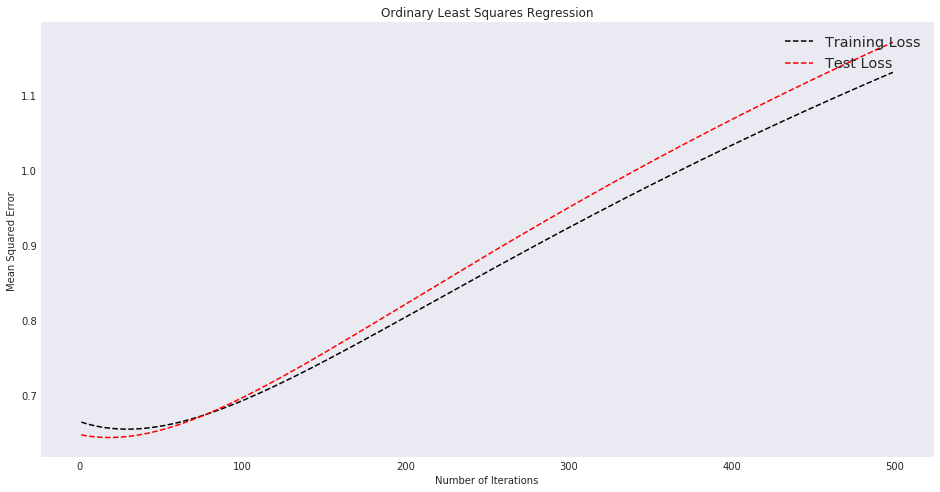

In [190]:
# take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )